### Imports
Importing all necessary libraries.

### Example run of the training

In [17]:
import torch

# Noise schedulers
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import DDPMPipeline

# Torch utils
import torch.nn.functional as F

In [18]:
import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [19]:
from DataObjects.DataLoader import DataLoader
from Architectures.DifussionModel import DiffusionModel
from Trainers.DiffusionTrainer import TrainingConfig

In [4]:
config = TrainingConfig()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
data_dir = "../Data/Raw/primary_data/cats/Data/"
batch_size = 32

Data_cats = DataLoader(data_dir, batch_size=batch_size, shuffle=True, fraction = 0.1, raw = True)
print(f"Number of cat batches: {len(Data_cats)}")
#Data_dogs = DataLoader(data_dir + '/dog/', batch_size=batch_size, shuffle=True)
#print(f"Number of dog batches: {len(Data_dogs)}")

Number of cat batches: 93


In [7]:
config.output_dir = "Unet_Logger_Test2"

In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [9]:
model = DiffusionModel.return_custom_arch(config)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [11]:
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(Data_cats) * config.num_epochs * config.train_batch_size),
)

In [12]:
from PIL import Image
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    image_grid = make_grid(images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration

from tqdm.auto import tqdm
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, device):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    device = accelerator.device

    if config.output_dir is not None:
        os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers("train_example")

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch.data.to(device)
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

In [14]:
train_dataloader = torch.utils.data.DataLoader(Data_cats, batch_size=config.train_batch_size, shuffle=True)

In [15]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, Data_cats, lr_scheduler, device)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


d:\Pulpit\DeepLearning\DeepLearning\Project_III\venv\Lib\site-packages\accelerate\accelerator.py:498: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Epoch 0:   0%|          | 0/93 [00:00<?, ?it/s]d:\Pulpit\DeepLearning\DeepLearning\Project_III\venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 74: 100%|██████████| 93/93 [01:12<00:00,  1.28it/s, loss=0.000839, lr=9.98e-5, step=6974]


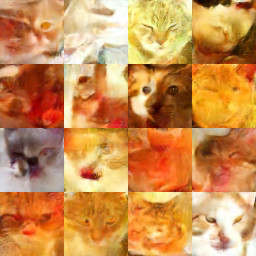

In [16]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

### Model weights loading

In [ ]:
from diffusers import DDPMPipeline
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipeline = DDPMPipeline.from_pretrained(
    config.output_dir,
    torch_dtype=torch.float16,
    use_safetensors=True    
)
pipeline.to(device)

Loading pipeline components...: 100%|██████████| 2/2 [00:08<00:00,  4.30s/it]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "Unet_Logger",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [ ]:
from PIL import Image

def generate(
    config,
    pipeline,
    batch_size=None,
    seed=None,
    grid_rows=None,
    grid_cols=None,
):
    # Determine settings
    bs = batch_size or config.eval_batch_size
    gen_seed = seed or config.seed
    generator = torch.manual_seed(gen_seed)

    # Sample!
    images = pipeline(batch_size=bs, generator=generator).images

    # Prepare output directory
    out_dir = os.path.join(config.output_dir, "generated")
    os.makedirs(out_dir, exist_ok=True)

    # Save each image
    for idx, img in enumerate(images):
        img.save(os.path.join(out_dir, f"image_{idx:04d}.png"))

    # Save a grid too
    rows = grid_rows or int(math.sqrt(bs))
    cols = grid_cols or rows
    grid = make_grid(images, rows=rows, cols=cols)
    grid.save(os.path.join(out_dir, "grid.png"))

    print(f"Saved {len(images)} images + grid at: {out_dir}")


In [ ]:
generate(config, pipeline)

100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Saved 16 images + grid at: Unet_Logger\generated


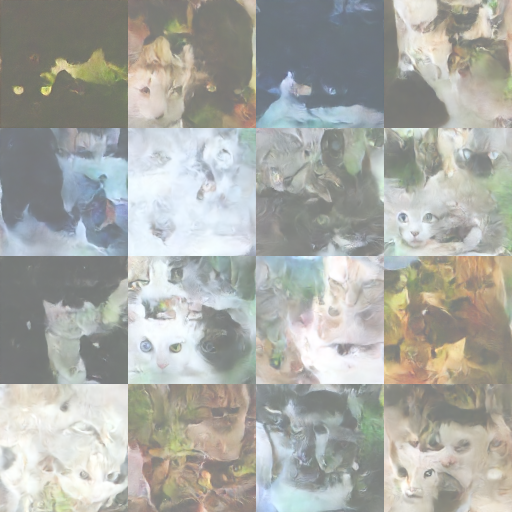

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/generated/grid.png"))
Image.open(sample_images[-1])